In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import seaborn as sns
import polars as pl
from polars import col
import plotly.express as px

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import xgboost as xgb

# EDA

In [2]:
data = pd.read_csv("data/PA6_cleaned_dataset.csv", index_col='time')
data.index = pd.to_datetime(data.index)

**The only null values we have are in the target variable "best price compound" and stretch over an 18 month period from "1/1/2015" to "6/1/2016"**

In [3]:
pl.from_pandas(data, include_index=True).null_count()

shape: (1, 21)
┌──────┬────────────────┬─────────────┬─────────────┬───┬────────────────┬────────────────┬───────────────┬────────────┐
│ time ┆ PA6 GLOBAL_    ┆ CRUDE_PETRO ┆ CRUDE_BRENT ┆ … ┆ Electricty_Pri ┆ Electricty_Pri ┆ Inflation_rat ┆ Automotive │
│ ---  ┆ EMEAS _ EUR    ┆ ---         ┆ ---         ┆   ┆ ce_Netherlands ┆ ce_Germany     ┆ e_france      ┆ Value      │
│ u32  ┆ per TON        ┆ u32         ┆ u32         ┆   ┆ ---            ┆ ---            ┆ ---           ┆ ---        │
│      ┆ ---            ┆             ┆             ┆   ┆ u32            ┆ u32            ┆ u32           ┆ u32        │
│      ┆ u32            ┆             ┆             ┆   ┆                ┆                ┆               ┆            │
╞══════╪════════════════╪═════════════╪═════════════╪═══╪════════════════╪════════════════╪═══════════════╪════════════╡
│ 0    ┆ 0              ┆ 0           ┆ 0           ┆ … ┆ 0              ┆ 0              ┆ 0             ┆ 0          │
└──────┴────────────────┴─────────────┴─────────────┴───┴────────────────┴────────────────┴───────────────┴────────────┘

## Y-label inspection

**Let us first inspect our Y-label: best_price_compound. From Schneider we know it is "our best SE buying price for PA6 compound in EUR/Kg in Europe, for confidentiality reasons, these values have been modified but the trends are the same."**

The best price is different from the variable 'PA6 GLOBAL_ EMEAS _ EUR per TON', because PA6 global is an index not a best price and for resin only. Whereas best_price compound is the real best price for the exact PA6 raw material we've defined in our product.

**Upon inspection we see that the best buy price initially varies on a monthly basis and then starting 1/1 2019 it varies either every 3 or every 6 months due to supplier contracts that fixed prices**

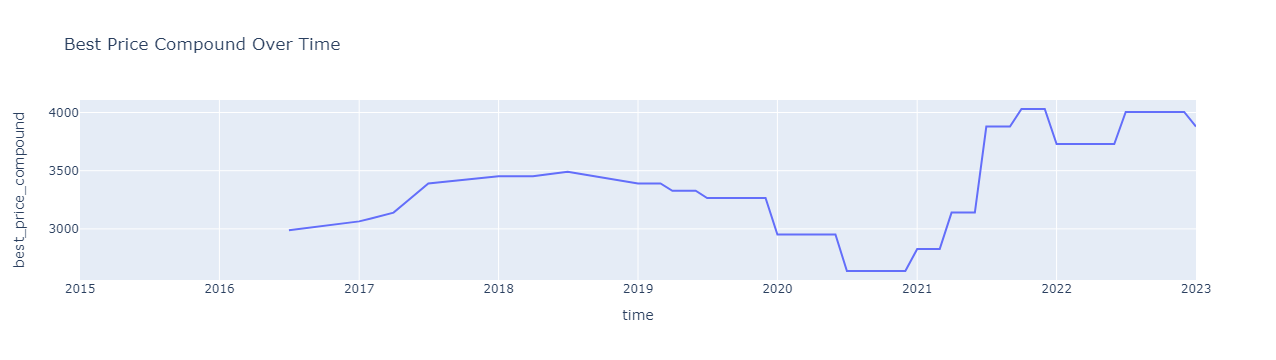

In [4]:
fig = px.line(data, x=data.index, y='best_price_compound', title='Best Price Compound Over Time')
fig.show()

**But in reality, this data before 2019 was most likely modified to have monthly variations, but most likely also had fixed prices for 3 or 6 months. We can see this in the plot below: for data before 2019 the best price is perfectly linear from quarter to quarter, which in reality never happens.**

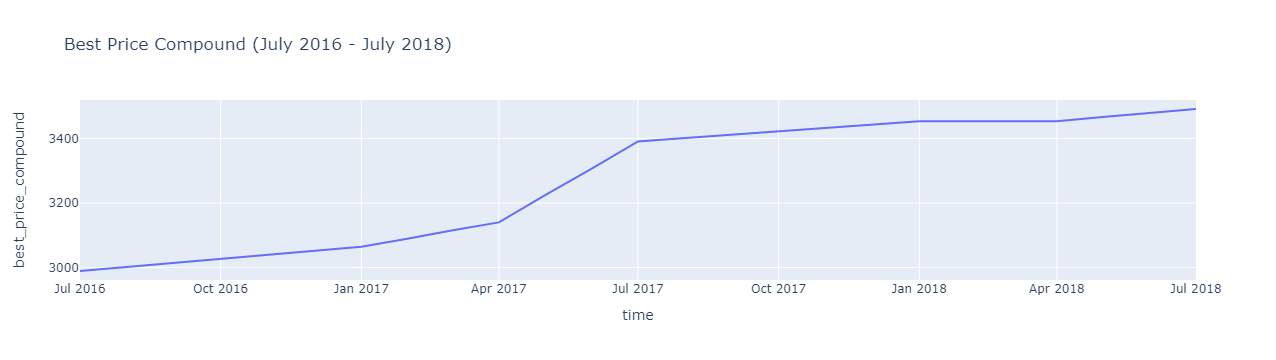

In [5]:
filtered_data = data[(data.index >= '2016-07-01') & (data.index <= '2018-07-31')]
fig = px.line(filtered_data, x=filtered_data.index, y='best_price_compound', title='Best Price Compound (July 2016 - July 2018)')
fig.show()


**So we already know that we have a particular type of Y-variable: it is the price Schneider is able to negociate every three months. Therefore, for our training we will be trying only to predict the Y-values in the beginning of the quarters.**

## Seasonal Decomposition

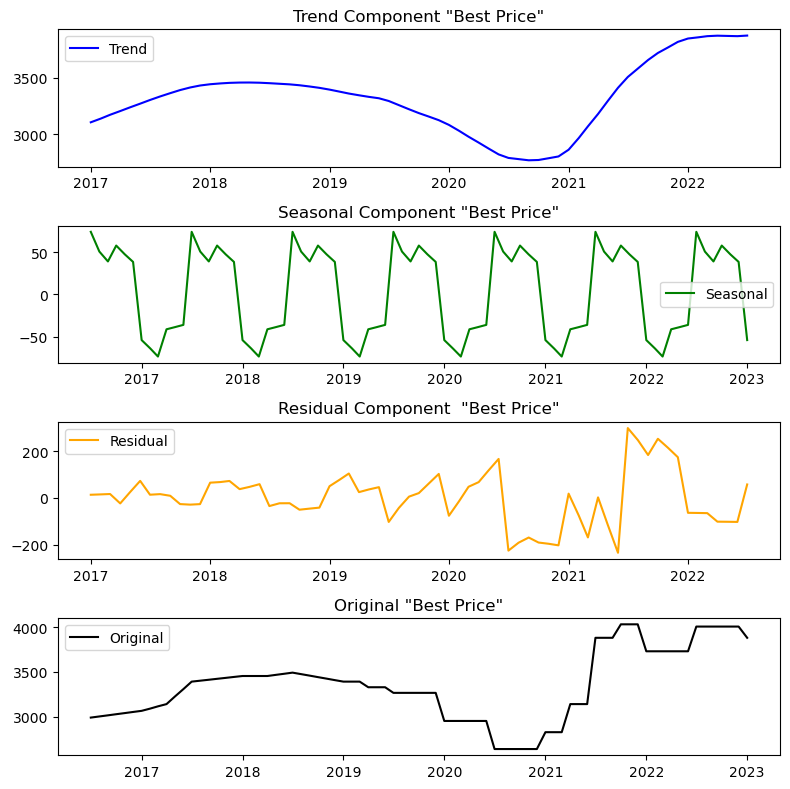

In [6]:
# Seasonal Decomposition
decomposition = seasonal_decompose(data.dropna()['best_price_compound'], model='additive', period=12) 
plt.figure(figsize=(8, 8))
# Trend component
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()
plt.title('Trend Component "Best Price"')
# Seasonal component
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend()
plt.title('Seasonal Component "Best Price"')
# Residual component
plt.subplot(413)
plt.plot(decomposition.resid, label='Residual', color='orange')
plt.legend()
plt.title('Residual Component  "Best Price"')
# Original time series
plt.subplot(414)
plt.plot(data['best_price_compound'], label='Original', color='black')
plt.legend()
plt.title('Original "Best Price"')
plt.tight_layout()
plt.show()

**Looking at our seasonal decomposition, the trend seems to dominate. The seasonal component is very marginal ranging from -50 to +50, which is less than 5% of the average best price and a fraction of the total variation**

**We have reason to believe that the trend is macro-economic: doing this same seasonal decomposition from CRUDE OIL and Inflation Rate in France, we see that the Trend component is near identical**

Text(0.5, 1.0, 'Trend Component CRUDE WTI')

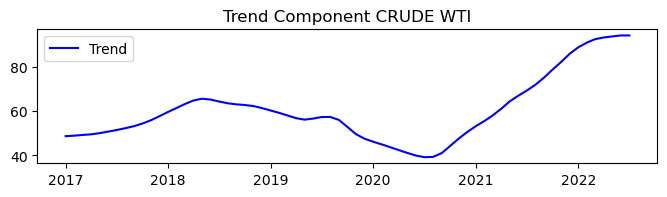

In [7]:
# Seasonal Decomposition
decomposition = seasonal_decompose(data.dropna()['CRUDE_WTI'], model='additive', period=12) 
plt.figure(figsize=(8, 8))
# Trend component
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()
plt.title('Trend Component CRUDE WTI')

Text(0.5, 1.0, 'Trend Inflation_rate_france')

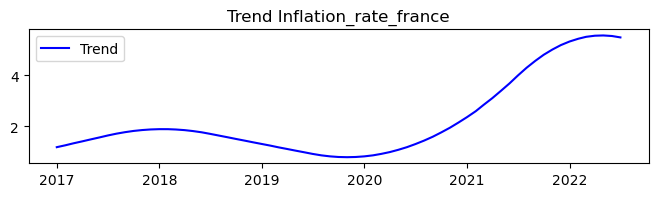

In [8]:
# Seasonal Decomposition
decomposition = seasonal_decompose(data.dropna()['Inflation_rate_france'], model='additive', period=12) 
plt.figure(figsize=(8, 8))
# Trend component
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()
plt.title('Trend Inflation_rate_france')

## Correlations External features

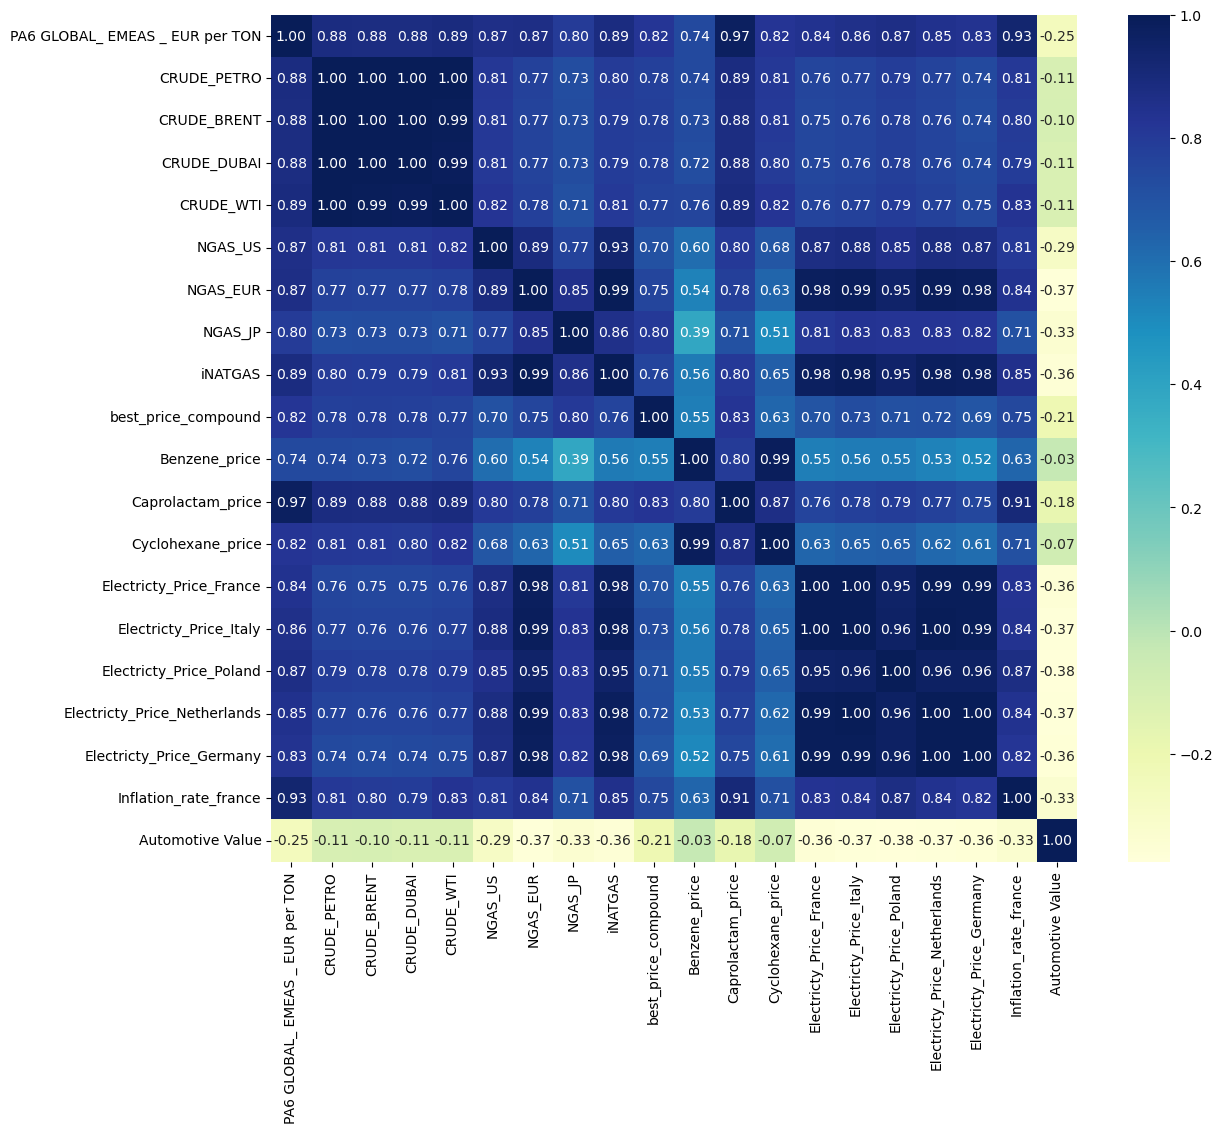

In [9]:
plt.figure(figsize=(13, 11))
sns.heatmap(data.corr(), annot=True, cmap = 'YlGnBu', fmt=".2f") 
plt.show()

## Plots by group

**Let us first look at the evolution of all of our variables. We are interested in observing common trends and correlations, so we will first rescale/normalize our variables so they range from 0 to 1, and then we will inspect them groupwise**

**First let's plot all variables together**  
There seems to be a general upwards trend towards the end of the period, but this view is too unclear, let us inspect the variables groupwise

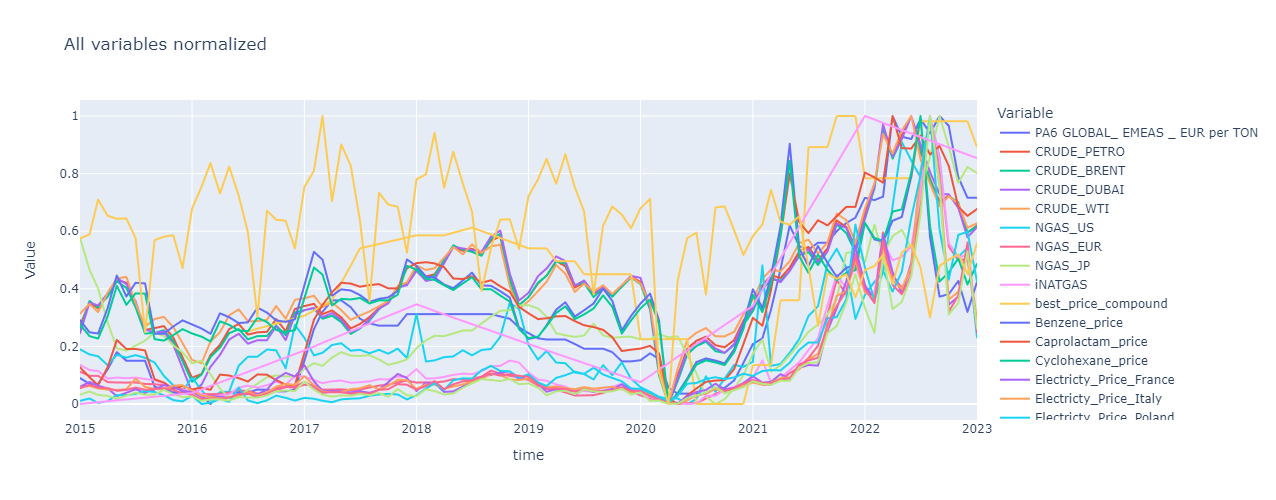

In [10]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
df_melted = df_normalized.reset_index().melt(id_vars=df_normalized.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_normalized.index.name, y='Value', color='Variable', title='All variables normalized')
fig.update_layout(width=1300, height=500)
fig.show()

We create groups by product similarity

In [11]:
petro = ['CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI', 'CRUDE_WTI']
gas = ['NGAS_US', 'NGAS_EUR', 'NGAS_JP', 'iNATGAS']
chemicals = ['Benzene_price', 'Caprolactam_price', 'Cyclohexane_price']
electricity = ['Electricty_Price_France', 'Electricty_Price_Italy', 'Electricty_Price_Poland','Electricty_Price_Netherlands', 'Electricty_Price_Germany']
rest = ['PA6 GLOBAL_ EMEAS _ EUR per TON', 'best_price_compound', 'Inflation_rate_france', 'Automotive Value']

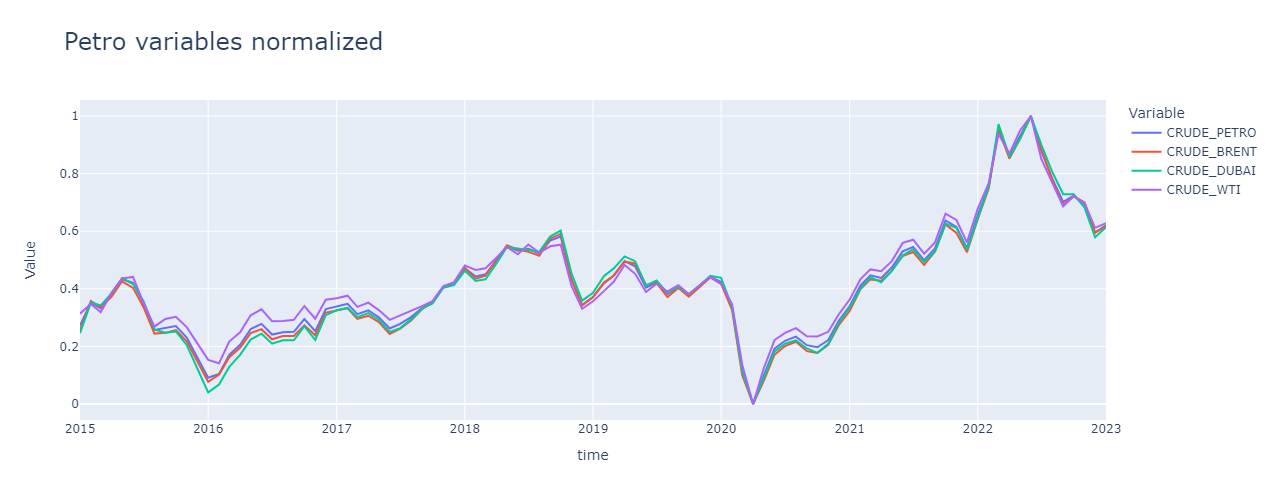

In [12]:
subcols = petro
df_selected = df_normalized.loc[:, subcols]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Petro variables normalized')
fig.update_layout(width=1100, height=500, title_font=dict(size=24))
fig.show()

**We can definitely regroup all petro columns into one, because they evolve near identically**

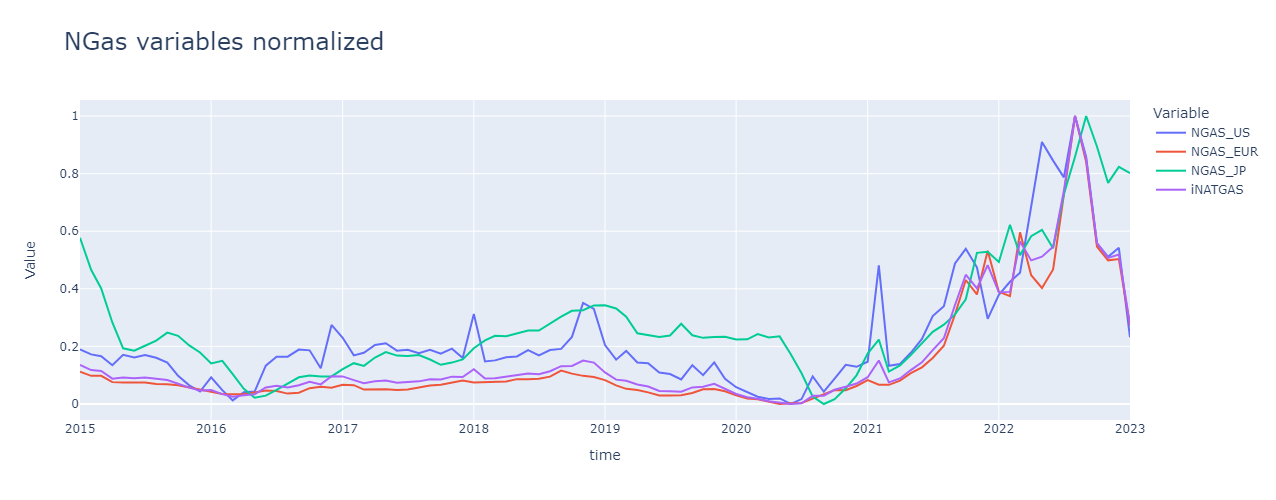

In [13]:
subcols = gas
df_selected = df_normalized.loc[:, subcols]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='NGas variables normalized')
fig.update_layout(width=1100, height=500, title_font=dict(size=24))
fig.show()

**Natural Gas indices are also highly correlated among themselves so we will take their average**

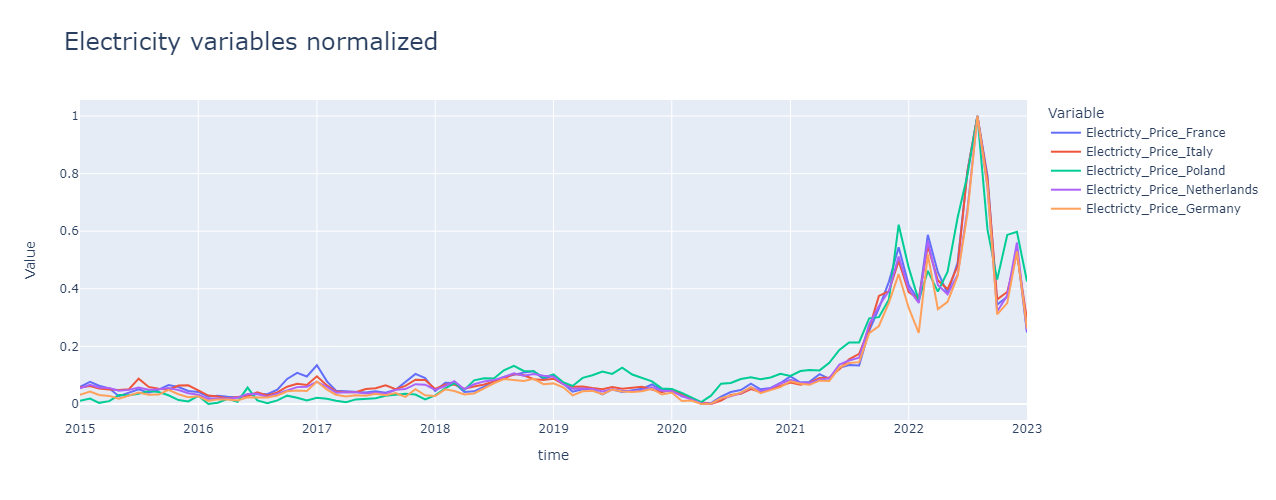

In [14]:
subcols = electricity
df_selected = df_normalized.loc[:, subcols]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Electricity variables normalized')
fig.update_layout(width=1100, height=500, title_font=dict(size=24))
fig.show()

**Electricity prices as well, we will average them or only consider that of one country, because the trends are the same**

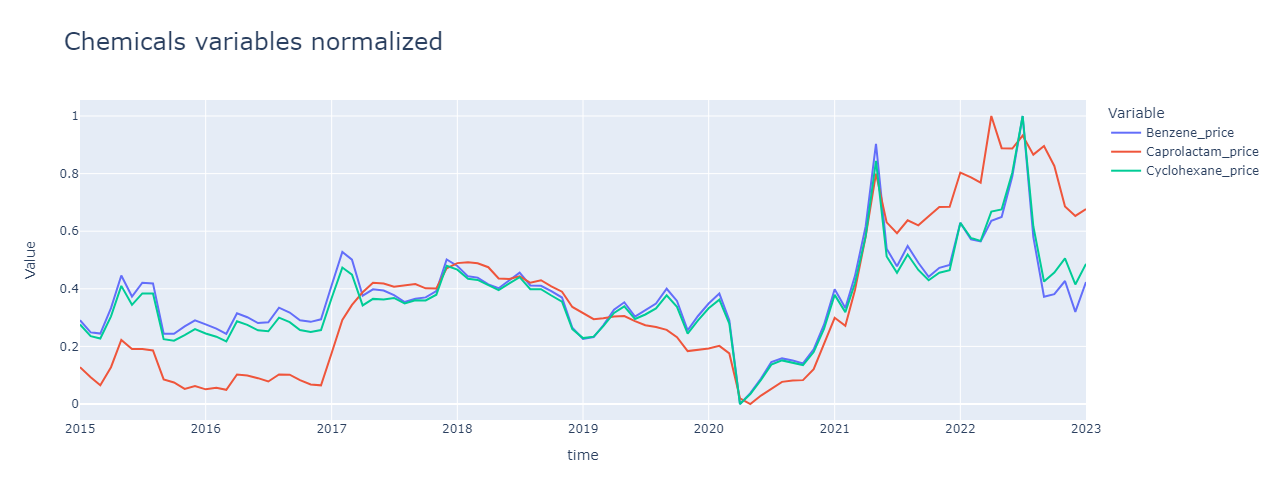

In [15]:
subcols = chemicals
df_selected = df_normalized.loc[:, subcols]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Chemicals variables normalized')
fig.update_layout(width=1100, height=500, title_font=dict(size=24))
fig.show()

**Benzene price has a 99% correlation with Cyclohexane so we will definitely only consider one of the two**

## Shift inspection

Our 3 main variables are: 
- **Caprolactam, because we know that it is the final compound from which PA6 is derived**
- **PA6 Global index, because PA6 is the underlying compound we are purchasing**
- **Best price compound because it is the best buying price we are trying to predict**

**Looking at these three variables, we observe a clear tendancy: the best price seems to follow the PA6 and Caprolactam price. There is a lead-lag relationship.**

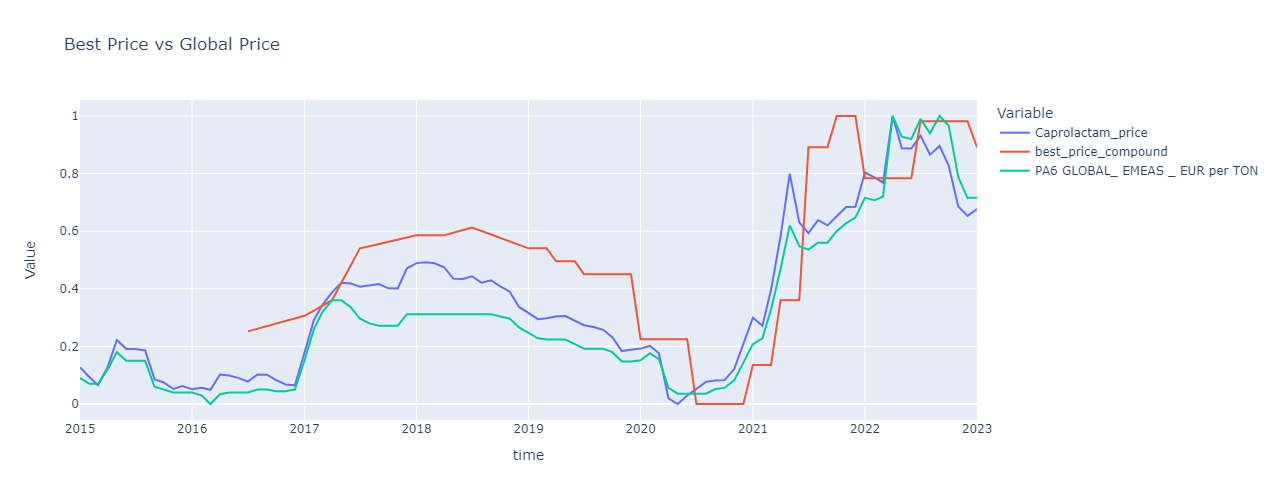

In [16]:
subcols = rest
df_selected = df_normalized.loc[:, ['Caprolactam_price', 'best_price_compound', 'PA6 GLOBAL_ EMEAS _ EUR per TON']]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Best Price vs Global Price')
fig.update_layout(width=1300, height=500)
fig.show()

**Let us shift forward Caprolactam by 1 to three months and look at the correlation with the best price.**

In [17]:
for i in range(1, 4):
    data[f'Caprolactam_price_shifted_{i}'] = data['Caprolactam_price'].shift(i)

In [18]:
initial_correlation = data['best_price_compound'].corr(data['Caprolactam_price'])
correlation_shift_1 = data['best_price_compound'].corr(data['Caprolactam_price'].shift(1))
correlation_shift_2 = data['best_price_compound'].corr(data['Caprolactam_price'].shift(2))
correlation_shift_3 = data['best_price_compound'].corr(data['Caprolactam_price'].shift(3))

(initial_correlation, correlation_shift_1, correlation_shift_2, correlation_shift_3)

(0.8267838625426043,
 0.8644378210539634,
 0.9113956539990598,
 0.9352717131730183)

**The correlation for shift 3 is the highest, which is what we observed above. Beneath let us plot the best price and the caprolactam price shifted forward by 3 months**

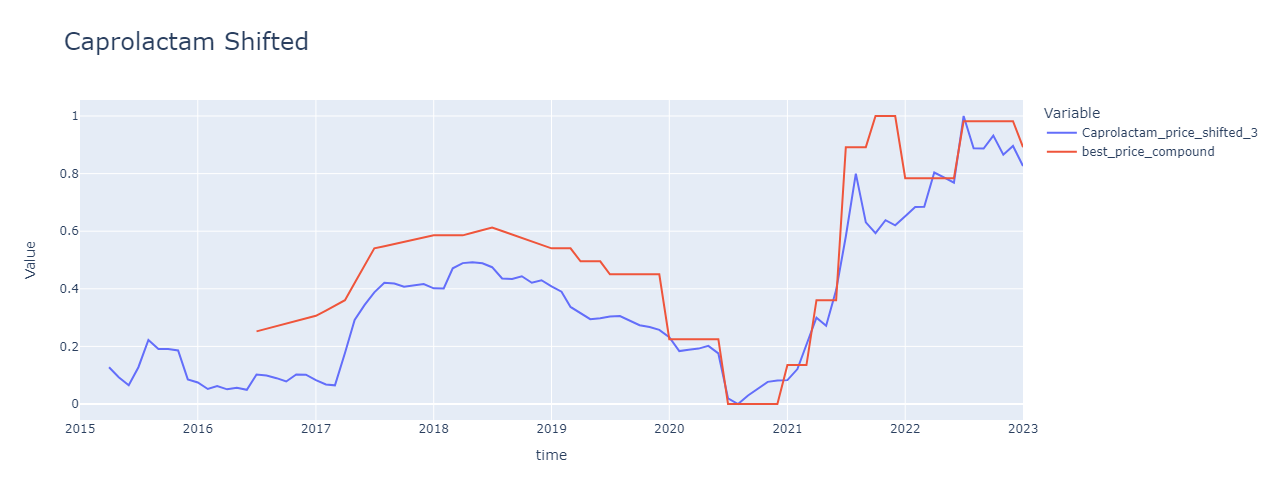

In [19]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
df_selected = df_normalized.loc[:, ['Caprolactam_price_shifted_3', 'best_price_compound']]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Caprolactam Shifted')
fig.update_layout(width=1100, height=500, title_font=dict(size=24))
fig.show()

# Feature Engineering

In [20]:
# Read the dataset, using the 'time' column as the index
data = pd.read_csv("data/PA6_cleaned_dataset.csv", index_col='time')

# Drop any rows where 'best_price_compound' is missing
data.dropna(subset=["best_price_compound"], inplace=True)

# Convert the index into datetime format for time series analysis
data.index = pd.to_datetime(data.index)

# Drop specified columns that are not needed for the analysis
data.drop(
    ['CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI', 'NGAS_US', 'NGAS_EUR', 'NGAS_JP', 
     'Cyclohexane_price', 'Electricty_Price_France', 'Electricty_Price_Italy', 
     'Electricty_Price_Poland', 'Electricty_Price_Netherlands'],
    axis=1, inplace=True)

# Extract the month from the index and create a new 'month' column
data["month"] = data.index.month

# Define custom dates for which we want to create empty rows
custom_dates = ['2023-02-10', '2023-03-01', '2023-04-01']
custom_index = pd.to_datetime(custom_dates)
empty_rows = pd.DataFrame(index=custom_index)

# Concatenate the main data with the empty rows to include the custom dates
data = pd.concat([data, empty_rows])

# For each column, create a new feature that is lagged by 1 time period
for col in data.columns:
    data[f"{col}_lag1"] = data[col].shift(1)
    
# For selected columns, create another feature that is lagged by 2 time periods
for col in ["PA6 GLOBAL_ EMEAS _ EUR per TON", "iNATGAS", "Electricty_Price_Germany", "Benzene_price", "Caprolactam_price"]:
    data[f"{col}_lag2"] = data[col].shift(2)

# Specifically for 'Caprolactam_price', create a lagged feature by 3 time periods
data['Caprolactam_price_lag_3'] = data['Caprolactam_price'].shift(3)

# Calculate the difference between the lagged features to create delta features
# These delta features can be useful for understanding changes between time periods
data["benzene_delta_lag1_lag2"] = data["Benzene_price_lag1"] - data["Benzene_price_lag2"]
data["iNATGAS_delta_lag1_lag2"] = data["iNATGAS_lag1"] - data["iNATGAS_lag2"]
data["Electricty_Germany_delta_lag1_lag2"] = data["Electricty_Price_Germany_lag1"] - data["Electricty_Price_Germany_lag2"]
data["PA6_delta_lag1_lag2"] = data["PA6 GLOBAL_ EMEAS _ EUR per TON_lag1"] - data["PA6 GLOBAL_ EMEAS _ EUR per TON_lag2"]

# Modeling

## Train-test split

In [21]:
# Filter the dataset for model training and testing
model_data = data[
    # Select data where the month is either January, April, July, or October (Q1, Q2, Q3, Q4)
    # and the date is between 2019-01-01 and before 2023-01-01
    (data["month"].isin([1, 4, 7, 10]) & (data.index >= '2019-01-01') & (data.index < '2023-01-01')) 
    # Include all data before 2019-01-01
    | (data.index < '2019-01-01')
    # Include all data from 2023-01-01 and onwards
    | (data.index >= '2023-01-01')
]

# Drop columns that are not available at the moment of prediction 
model_data = model_data.drop([
    "PA6 GLOBAL_ EMEAS _ EUR per TON",
    "CRUDE_WTI",
    "iNATGAS",
    "Benzene_price",
    "Caprolactam_price",
    "Electricty_Price_Germany",
    "Inflation_rate_france",
    "month",
    "Automotive Value",
    #Now we also drop the lag 2 because we have the deltas
    "PA6 GLOBAL_ EMEAS _ EUR per TON_lag2",
    "iNATGAS_lag2",
    "Electricty_Price_Germany_lag2",
    "Benzene_price_lag2",
    "Caprolactam_price_lag2"]
    , axis=1
)

# Define a cutoff date to split the data into training and test sets
train_test_date = '2020-01-01'

# Remove the initial rows where the lagged values would be NaN due to the shifting operation
model_data = model_data.query("index > '2016-09-01'").copy()
train_data = model_data.query(f"index < '{train_test_date}'")
test_data = model_data.query(f"index < '2023-01-01' and index >= '{train_test_date}'")

# Separate the data for submission or future prediction, starting from 2023-01-01 onwards
submission_data = model_data.query("index >= '2023-01-01'")

## 1-month ahead model

In [22]:
# Initialize the StandardScaler
scaler = StandardScaler()

X_train = train_data.drop("best_price_compound", axis=1)
y_train = train_data["best_price_compound"]
X_test = test_data.drop("best_price_compound", axis=1)
y_test = test_data["best_price_compound"]

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the LinearRegression model
model_1_month_linear = linear_model.LinearRegression()
model_1_month_linear.fit(X_train_scaled, y_train)

# Predict with the normalized test data
y_pred = model_1_month_linear.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, index=y_test.index).rename(columns={0: "pred"})

# Calculate the mean absolute error and mean absolute percentage error
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Over the test set 2020-2022 our average mean absolute error is {round(mae, 2)}')
print(f'Over the test set 2020-2022 our average mean absolute percentage error is {100 * round(mape, 4)}%')

Over the test set 2020-2022 our average mean absolute error is 193.99
Over the test set 2020-2022 our average mean absolute percentage error is 5.88%


### Plots

Text(0.5, 1.0, 'Predicted vs true best price, one month before quarter begin')

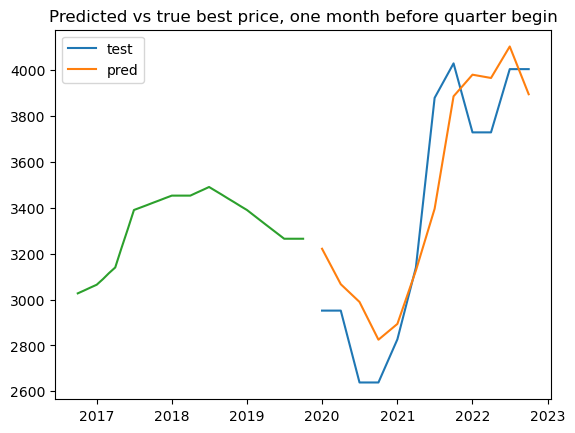

In [23]:
plt.plot(y_test, label="test")
plt.plot(y_pred, label="pred")
plt.plot(y_train)
plt.legend()
plt.title("Predicted vs true best price, one month before quarter begin")

**Now we plot the same thing but with quarterly plateaus**

In [24]:
def fill_gaps(df):
    min_date = df.index.min()
    max_date = df.index.max()

    # Generate all dates between the minimum and maximum dates at a monthly frequency
    complete_dates = pd.date_range(min_date, max_date, freq='MS')

    # Create a DataFrame with the complete date index
    complete_df = pd.DataFrame(index=complete_dates)

    # Merge the original DataFrame with the DataFrame containing the complete date index
    result_df = pd.merge(complete_df, df, left_index=True, right_index=True, how='left')

    # Display the result DataFrame
    return result_df.fillna(method='ffill')


Text(0.5, 1.0, 'Predicted vs true best price, one month before quarter begin, with plateau')

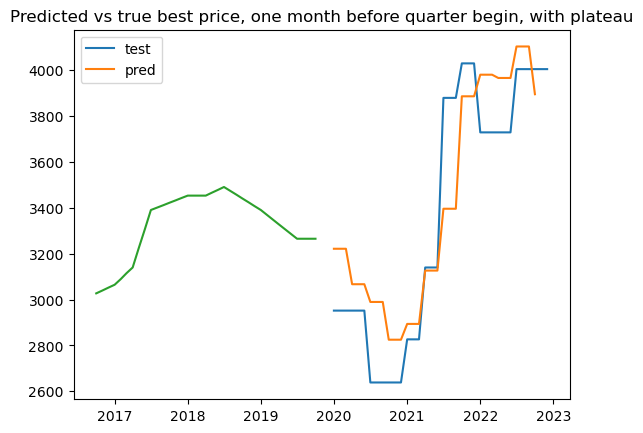

In [25]:
full_test = data[["best_price_compound"]].query(f"index < '2023-01-01' and index >= '{train_test_date}'")
plt.plot(full_test, label="test")
plt.plot(fill_gaps(y_pred), label="pred")
plt.plot(y_train)
plt.legend()
plt.title("Predicted vs true best price, one month before quarter begin, with plateau")

### Feature importance

This is the feature importance of the model trained only until 2020

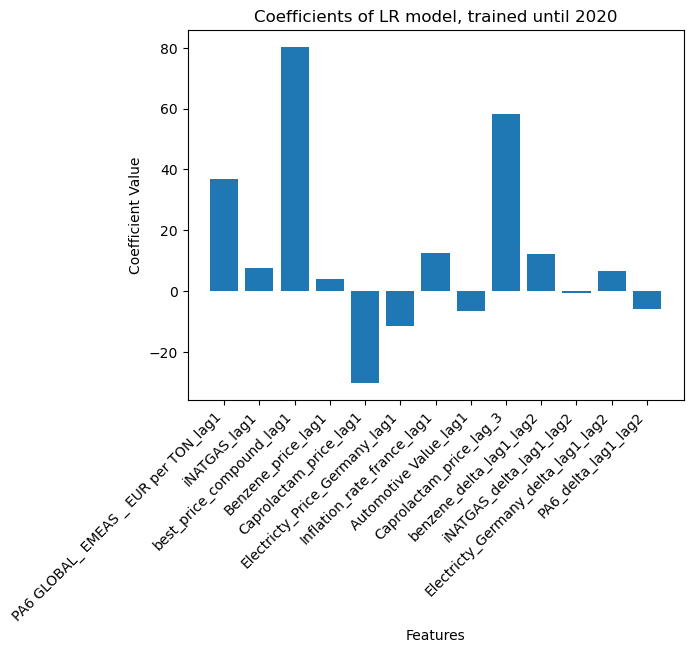

In [26]:
coefficients = model_1_month_linear.coef_
intercept = model_1_month_linear.intercept_

selected_features = X_train.columns[abs(coefficients) > 0.5]
selected_coefficients = coefficients[abs(coefficients) > 0.5]

# Plotting the coefficients
feature_names = X_train.columns
plt.bar(selected_features, selected_coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of LR model, trained until 2020')
plt.xticks(rotation=45, ha='right')
plt.show()

This is the feature importance of the model trained on the whole duration until 12/1/2023

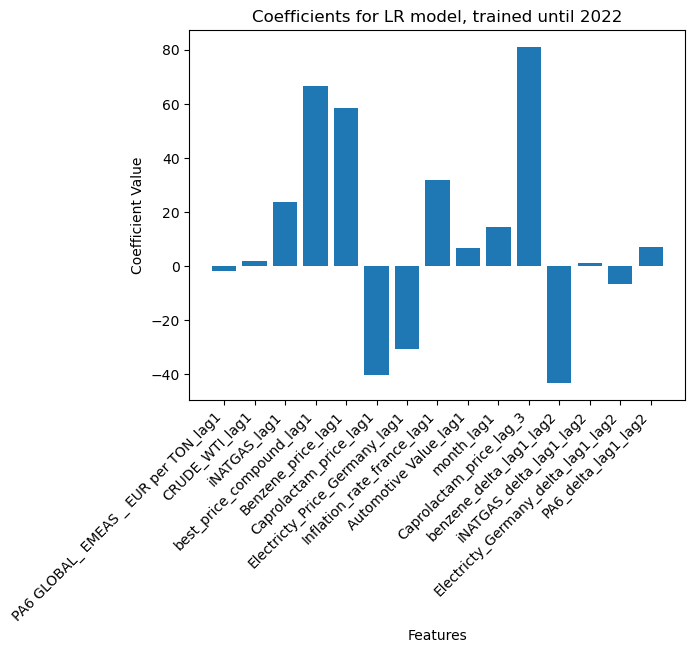

In [27]:
model_data2 = model_data.copy().query(f"index < '{'2023-01-01'}'")
X_full = model_data2.drop("best_price_compound", axis=1)
y_full = model_data2["best_price_compound"]
X_full_rescaled = scaler.transform(X_full)

model_1_month_linear_full = linear_model.LinearRegression()
model_1_month_linear_full.fit(X_full_rescaled, y_full)

coefficients_full = model_1_month_linear_full.coef_
intercept_full = model_1_month_linear_full.intercept_

selected_features_full = X_full.columns[abs(coefficients_full) > 0.5]
selected_coefficients_full = coefficients_full[abs(coefficients_full) > 0.5]

# Plotting the coefficients
feature_names = X_full.columns
plt.bar(selected_features_full, selected_coefficients_full)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients for LR model, trained until 2022')
plt.xticks(rotation=45, ha='right')
plt.show()

### Prediction 01/01/2023

For this prediction we will use the model trained on the full data.

In [28]:
X_sub = submission_data.drop("best_price_compound", axis=1).iloc[:1]
X_sub = scaler.transform(X_sub)
prediction_1m = model_1_month_linear_full.predict(X_sub)
print(f"Prediction for 01/01/2023 is {round(prediction_1m[0], 2)}")

Prediction for 01/01/2023 is 3697.99


## 4&7 month ahead SARIMAX

**For the 4 and 7-month ahead predictions we will first use SARIMAX to predict 3 months ahead for all our features X and then use a linear 1-month ahead model to predict the 4-month best price.**

### SARIMAX on features

In [29]:
# Function to split the data into training and test sets based on a specific date.
def get_train_test_split(data, column, date):
    # Training set: Select data where the index (date) is before the specified split date
    train = data[[column]].query(f"index < '{date}'")
    test = data[[column]].query(f"index >= '{date}'")
    return train, test  

In [30]:
# The date used to split the data into training and test sets
date_split = '2023-01-01'
# Set the frequency of the DataFrame index to Month Start ('MS').
data = data.asfreq('MS')

# Split the data for each feature using the function defined above and the specified date.
train_pa6, test_pa6 = get_train_test_split(data, "PA6 GLOBAL_ EMEAS _ EUR per TON", date_split)
train_capro, test_capro = get_train_test_split(data, "Caprolactam_price", date_split)
train_benzene, test_benzene = get_train_test_split(data, "Benzene_price", date_split)
train_elec, test_elec = get_train_test_split(data, "Electricty_Price_Germany", date_split)

features_train_test = [
    (train_pa6, test_pa6),
    (train_capro, test_capro),
    (train_benzene, test_benzene),
    (train_elec, test_elec)
]

# Specify the order and seasonal_order based on your analysis
order = (1, 1, 1)  # Example order (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Example seasonal_order (P, D, Q, s)

features_pred = {}
for (train, test), feature in zip(features_train_test, ["PA6", "Caprolactame", "Benzene", "Electricity"]):
    # Create and fit the SARIMAX model
    sarimax_model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
    sarimax_result = sarimax_model.fit()

    # Make predictions on the test set
    predictions = sarimax_result.get_forecast(steps=7)
    predicted_values = predictions.predicted_mean
    features_pred[feature] = predicted_values

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



In [31]:
train = train_elec
test = test_elec
# Specify the order and seasonal_order based on your analysis
order = (1, 1, 1)  # Example order (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Example seasonal_order (P, D, Q, s)

# Create and fit the SARIMAX model
sarimax_model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
sarimax_result = sarimax_model.fit()

# Make predictions on the test set
predictions = sarimax_result.get_forecast(steps=len(test))
predicted_values = predictions.predicted_mean

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



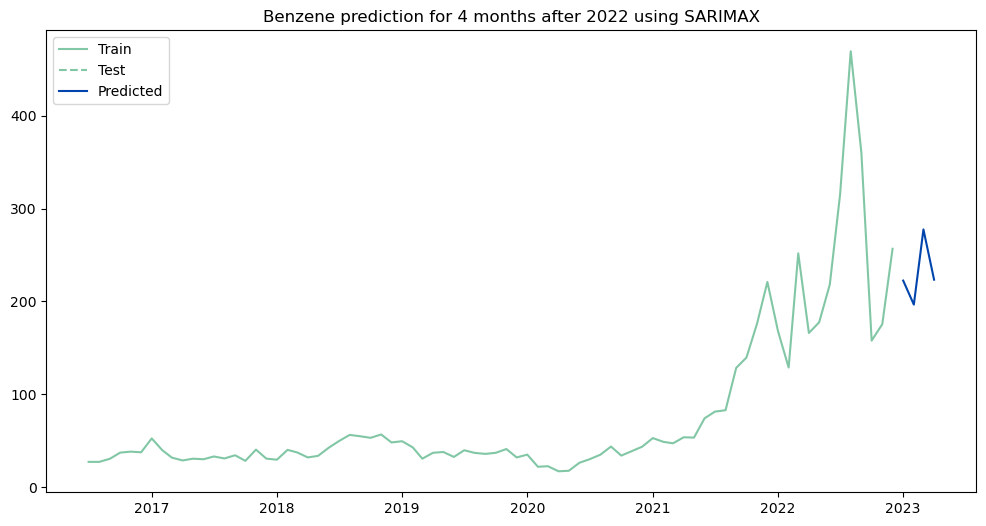

In [32]:

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train', color="#82c7a5")
plt.plot(test.index, test.values, label='Test', color="#82c7a5", linestyle="--")
plt.plot(test.index, predicted_values, label='Predicted', color='#0145ac')
plt.title("Benzene prediction for 4 months after 2022 using SARIMAX")
plt.legend()
plt.show()


**Then for the other main features we also make predictions using SARIMAX**

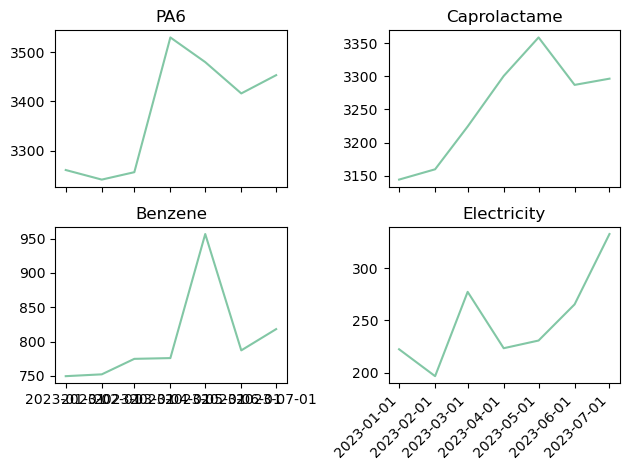

In [33]:
df_pred = pd.DataFrame(features_pred)
f, axes = plt.subplots(2, 2, sharex=True)
(sp1, sp2), (sp3, sp4) = axes[0], axes[1]
for col, sp in zip(df_pred.columns, [sp1, sp2, sp3, sp4]):
    sp.plot(df_pred[col], label=col, color="#82c7a5")
    sp.set_title(col)
    #plt.xticks(rotation=45, ha='right')
    #sp.set_xticklabels(sp.get_xticks(), rotation=45, ha='right')
    sp.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set date formatter
    #sp.xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
plt.xticks(rotation=45, ha='right')
f.tight_layout()

### Retrain linear model

**Retrain a 4 month model based on these prediction**

In [34]:
data = pd.read_csv("data/PA6_cleaned_dataset.csv", index_col='time')
data.dropna(subset="best_price_compound", inplace=True)
data.index = pd.to_datetime(data.index)

# For the long term prediction mode, only keep the 4 features predicted with sarima
data = data[["PA6 GLOBAL_ EMEAS _ EUR per TON", "best_price_compound", "Benzene_price", "Caprolactam_price", "Electricty_Price_Germany"]].copy()

# Rename df_pred to make it match with original data
df_pred.rename(
    columns={"PA6": "PA6 GLOBAL_ EMEAS _ EUR per TON", "Benzene": "Benzene_price", "Caprolactame": "Caprolactam_price", "Electricity": "Electricty_Price_Germany"},
    inplace=True
)

data.drop("2023-01-01", inplace=True)
data = pd.concat([data, df_pred])
data["month"] = data.index
data["month"] = pd.to_datetime(data["month"])
data["month"] = data["month"].dt.month

for col in data.columns:
    if col == "best_price_compound":
        continue
    data[f"{col}_lag1"] = data[col].shift(1)
    data[f"{col}_lag2"] = data[col].shift(2)

data['Caprolactam_price_lag_3'] = data['Caprolactam_price'].shift(3)

# data["benzene_price_delta"] = data["Benzene_price_lag1"] - data["Benzene_price_lag2"]
# data["Electricty_Price_Germany_delta"] = data["Electricty_Price_Germany_lag1"] - data["Electricty_Price_Germany_lag2"]
# data["PA6 GLOBAL_ EMEAS _ EUR per TON_delta"] = data["PA6 GLOBAL_ EMEAS _ EUR per TON_lag1"] - data["PA6 GLOBAL_ EMEAS _ EUR per TON_lag2"]

In [36]:
lt_model_data = data[
    (data["month"].isin([1, 4, 7, 10]) & (data.index >= '2019-01-01'))
    | (data.index < '2019-01-01')
]

lt_model_data = lt_model_data.drop([
    "PA6 GLOBAL_ EMEAS _ EUR per TON",
    "Benzene_price",
    "Caprolactam_price",
    "Electricty_Price_Germany",
    "month",]
    , axis=1
)

train_test_date = '2020-01-01'

# Remove first data rows, where lag value is NaN
lt_model_data = lt_model_data.query("index > '2016-09-01'").copy()
lt_train_data = lt_model_data.query(f"index < '{train_test_date}'")
lt_test_data = lt_model_data.query(f"index < '2023-01-01' and index >= '{train_test_date}'")
lt_submission_data = lt_model_data.query("index >= '2023-01-01'")


In [37]:
model_lt_month_linear = linear_model.LinearRegression()

X_train_lt = lt_train_data.drop("best_price_compound", axis=1)
y_train_lt = lt_train_data["best_price_compound"]

X_test_lt = lt_test_data.drop("best_price_compound", axis=1)
y_test_lt = lt_test_data["best_price_compound"]

model_lt_month_linear.fit(X_train_lt, y_train_lt)
y_pred_lt = model_lt_month_linear.predict(X_test_lt)
y_pred_lt = pd.DataFrame(y_pred_lt, index=y_test_lt.index).rename(columns={0: "pred"})

mae_4m = mean_absolute_error(y_pred_lt, y_test_lt)
mape_4m = mean_absolute_percentage_error(y_pred_lt, y_test_lt)

print(f'Over the test set 2020-2022 our average mean absolute error is {round(mae_4m, 2)}')
print(f'Over the test set 2020-2022 our average mean absolute percentage error is {100 * round(mape_4m, 4)}%')

Over the test set 2020-2022 our average mean absolute error is 242.23
Over the test set 2020-2022 our average mean absolute percentage error is 7.22%


### Plots

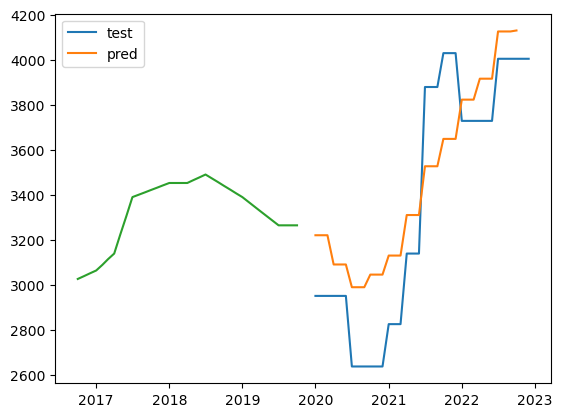

In [38]:
full_test = data[["best_price_compound"]].query(f"index < '2023-01-01' and index >= '{train_test_date}'")
plt.plot(full_test, label="test")
plt.plot(fill_gaps(y_pred_lt), label="pred")
plt.plot(y_train_lt)
plt.legend()

Now that we estimated the error on the long term model, we can retrain it on all the data, and get the prediction for 6 and 9 months

### Final Predictions

In [39]:
X_sub = lt_submission_data.drop('best_price_compound', axis=1)
prediction_lt = model_lt_month_linear.predict(X_sub)
print(f"Prediction for 1 month is {prediction_lt}")

Prediction for 1 month is [3876.78088231 3884.98238465 3922.76057038]
